In [1]:
import matplotlib.pyplot as mp
import numpy as np
import metpy.calc as mpy
from metpy.units import units
import xarray as xr
import datetime as dt
from pylab import *


##### SCAM FORCINGS GENERATION Fntsnaps = OR SAS PARAMETERS IN #####
### http://www2.mmm.ucar.edu/people/patton/documents/su_et_al.ACP.2016.pdf ###
### Better from EGU/ACP website: https://www.atmos-chem-phys.net/16/7725/2016/
## Time ##

##### IOP file info. #####

iop_file_in = './ARM95_4scam_c180703.nc'   # Input template
iop_file_out = './SAS_ideal_4scam_16.nc' # Output forcing file

bdate = 20130610

spd = 86400 # Seconds per day
sph = 3600  # Seconds per hour
mpd = 1440  # Mins per day
spm = 60    # Seconds per minute.

dtime = 2*spm    # Time interval (minutes*60=sec) for each time point on file (does not have to be DTIME)
tperiod = (16.5-6)*sph+dtime    # Time length (hours*sph=sec) for whole of IOP
iop_zstart = 12*sph  # 12Z = 6AM MST (US)

iop_lat =  32.5 # Lat location (SAS average of two smapling sites)
iop_lon = -87.15 # Lon

lno_lsf = False # Set large scale forcings to zero.
liop_lev = False # Take levels from existing IOP

vdesc = ('Initial BL height', \
         'Subsidence rate', \
         'Surface sensible heat flux',\
         'Surface latent heat flux',\
         'Entrainment/surface heat flux ratio'\
         'Initial BL potential temperature',\
         'Initial FT potential temperature',\
         'Potential temperature lapse rate FT',\
         'Advection of potential temperature',\
         'Initial BL specific humidity',\
         'Initial FT specific humidity',\
         'Specific humidity lapse rate FT',\
         'Advection of specific humidity')


vname = ('pblh','w_sub','shflx','lhflx','eratio','the_bl','the_trop','the_lr','the_adv','q_bl','q_trop','q_lr','q_adv')
#vval =  (500,    9.e-6,   0.1,   0.15,    0.2,     296.6,   298.1,     0.003,   6.4e-4, 16.8,    12.8,   -0.004,   1.5e-4) # paper values
vval =   (500,    9.e-6,   0.1,   0.15,    0.2,     296.6,   298.1,     0.003,   0., 16.8,    12.8,   -0.004,   0.) # current values


### Need constants ###

r_gas = 287.   # Specific gas constant for dry air
cp_air = 1004.6 # Specific heat for dry air
Lv = 2.501e6      # Latent heat of vaporization

r_cp = r_gas/cp_air    # r/cp
grav = 9.81     # Gravity ave.


####### GRAPHICS ########
#mp.interactive(True)
%matplotlib qt



## Read in and IOP template ##
iop_in = xr.open_dataset(iop_file_in,engine='netcdf4') # This is like addfile -> pointer

## Add Time (tsec) Array Based on time information ##
ntsteps = int(tperiod/dtime)
time = iop_zstart+dtime*np.arange(ntsteps)

#### Set levels for the IOP file or specified (mb) ####
if liop_lev: 
    plevs = iop_in['lev']
else:    
    pmin,pmax,delp = 100.,1000.,10. 
    plevs = 100.*np.arange(pmin,pmax,delp)


nplevs = plevs.size
## Set up a basic 3D/4D DataArray that will be written into the new DataSet
var_4d = np.zeros((ntsteps,nplevs,1,1),dtype=np.float32) # Set-up
var_3d = np.zeros((ntsteps,1,1),  dtype=np.float32) # Set-up

iop_out_c4 = ('time','lev','lat','lon')   # Coordinates for iop_out
iop_out_c3 = ('time','lat','lon')
              

Text(0, 0.5, 'W/m$^2$')

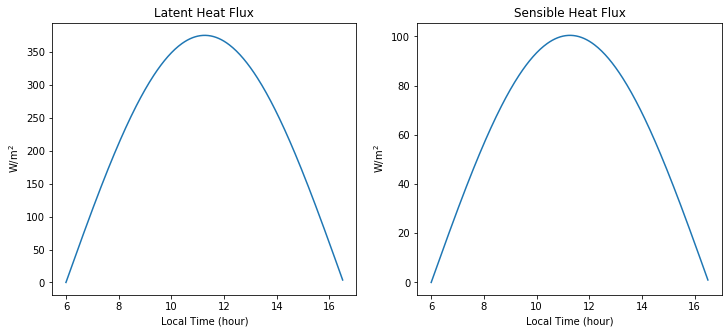

In [2]:

###### Construct time varying data for 3d arrays (time,lat,lon) ######

## Generate boundary forced variables ##
shflx0 = vval[vname.index('shflx')]
vdesc_i = vdesc[vname.index('shflx')]

lhflx0 = vval[vname.index('lhflx')]
vdesc_i = vdesc[vname.index('lhflx')]

## SAS case study: Daylight variation of sfce fluxes (sfc fluxes to be converted to energy flux) ##
shflx = np.copy(var_3d)  
shflx[:,0,0] = shflx0*cp_air*np.sin(np.pi*(time-iop_zstart)/tperiod)

## Initialize "Dataset" ##
iop_out = xr.Dataset({'shflx': (['time','lon','lat'],  shflx)},
                     coords={'tsec': ('tsec',time),  
                             'lev': ('lev',np.float32(plevs)), 
                             'lon': ('lon',[np.float32(iop_lon)]), 
                             'lat': ('lat', [np.float32(iop_lat)]) })

## IOP out add attributes ##
iop_out.attrs['title'] = 'Southeast Atmosphere Study (SipAS) campaign: Ideal day for the Mixed Layer Model (MXLCH, it can be accessed athttps://github.com/classmodel/mxlch)'
iop_out.attrs['iop_file'] = iop_file_out
iop_out.attrs['publication'] = 'https://doi.org/10.5194/acp-16-7725-2016'
iop_out.attrs['creation_date'] = str(dt.datetime.today())
iop_out.attrs['creation_date'] = 'Rich Neale, NCAR'

## Dimenstion/Coord info.
iop_out.lat.attrs = iop_in.lat.attrs
iop_out.lon.attrs = iop_in.lon.attrs

## Copy attributes of tsec from iop_in ##
iop_out.lev.attrs = iop_in.lev.attrs
iop_out.tsec.attrs['long_name'] = iop_in.tsec.attrs['long_name'] 
iop_out.tsec.attrs['units'] = iop_in.tsec.attrs['units'] 

## LHFLX ##
lhflx = np.copy(var_3d)  
lhflx[:,0,0] = 0.001*lhflx0*Lv*np.sin(np.pi*(time-iop_zstart)/tperiod) # Convert g/kg -> kg/kg
iop_out['lhflx'] = (iop_out_c3, lhflx)

## Quick plots ##

fig,ax = mp.subplots(nrows=1, ncols=2,figsize=(12, 5))

ax[0].plot((time/sph)-6,lhflx[:,0,0]) ; ax[0].set_title('Latent Heat Flux') ; ax[0].set_xlabel('Local Time (hour)') ; ax[0].set_ylabel('W/m$^2$') 
ax[1].plot((time/sph)-6,shflx[:,0,0]) ; ax[1].set_title('Sensible Heat Flux') ; ax[1].set_xlabel('Local Time (hour)') ; ax[1].set_ylabel('W/m$^2$') 



[153.63327962 157.87399751 161.84759964 165.59121948 169.13442564
 172.50118457 175.71121886 178.78097295 181.72431603 184.55306391
 187.27737367 189.9060467  192.44676476 194.9062762  197.29054453
 199.60486824 201.85397827 204.04211807 206.17310981 208.25040965
 210.27715402 212.25619878 214.1901525  216.08140482 217.93215089
 219.74441233 221.52005555 223.26080757 224.96826987 226.64393059
 228.2891752  229.90529597 231.49350035 233.05491836 234.5906093
 236.10156761 237.58872822 239.05297131 240.49512658 241.91597718
 243.31626317 244.69668471 246.05790495 247.40055268 248.72522466
 250.03248787 251.32288149 252.5969187  253.85508843 255.09785684
 256.32566878 257.53894909 258.73810381 259.92352132 261.09557333
 262.2546159  263.40099029 264.5350238  265.65703053 266.76731213
 267.86615843 268.95384806 270.03064909 271.0968195  272.15260773
 273.19825317 274.23398656 275.26003045 276.27659959 277.28390127
 278.2821357  279.27149633 280.25217015 281.224338   282.18817481
 283.143849

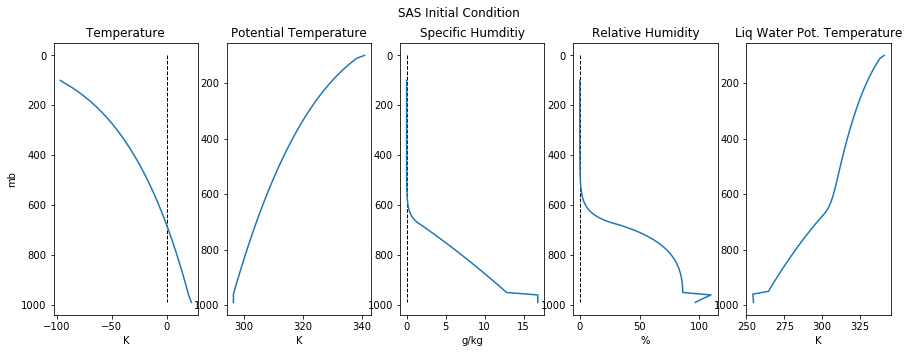

In [3]:
######################################
### Constructing vertical profiles ###
######################################

## Read in SCAM IOP template here (split into a function at some point)
#plevs = np.array([10, 20, 100, 150, 200, 300, 400, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 975, 1000])
#plevs = np.arange(10,1000,10)


## Convert trop theta values into temperature given plevs ##
#plevs = iop_in['lev']


ps = 101500. # psurf [pa]
p0 = 100000. # pref [pa]

## Z of plevels, tricky don't have T yet ##
dp_levs = np.diff(plevs)


################################
## 1. Grab CASE values ##
################################

pblh =  vval[vname.index('pblh')]

the_ft = vval[vname.index('the_trop')]
the_bl = vval[vname.index('the_bl')]
dthedp_ft =  vval[vname.index('the_lr')]

q_ft = vval[vname.index('q_trop')]
q_bl = vval[vname.index('q_bl')]
dqdp_ft = vval[vname.index('q_lr')]


################################
## 2. Find PBL top level ##
################################

# Temperature profile based just on the_bl
t_bl = the_bl*(plevs/p0)**r_cp  
print(t_bl)
# Assumed t is just below 800mb
p_bl_top = 80000. # hpa estimate pf PBL top.
t_bl_ave = np.average(t_bl[np.where(plevs >= p_bl_top)])

# Z levels based on t_bl
z_plevs = (r_gas/grav)*t_bl*np.log(ps/plevs)

# Where's the PBL?
ipbl_levs = np.where(z_plevs <= pblh)
npbl_levs = np.size(ipbl_levs)
nft_levs = nplevs-npbl_levs

ipbl_min = np.amin(ipbl_levs)


##############################################################
## 3. Use Gradient+mean and specified theta, q for profiles ##
##############################################################

q_plevs = np.full(nplevs, q_bl)
the = np.full(nplevs, the_bl) # Initialize theta pbl as numpys

# Construct profiles in the FT, starting at ipbl+ and working up

for ip in range(ipbl_min-1,-1,-1):
    
    # Temp profile
    t_ip = the[ip-1]*(plevs[ip-1]/p0)**r_cp # Temp at the level below
 
    rho = plevs[ip]/(r_gas*t_ip)  # Density at lev-=ip
    dz = dp_levs[ip]/(rho*grav)
    the[ip] = the[ip+1]+dthedp_ft*dz
    
    # q profile 

    # Try dropping the value of q above the PBL top straight to the FT value
    
    if ip == ipbl_min-1: 
        q_plevs[ip] = q_ft
    else:
        q_plevs[ip] = q_plevs[ip+1]+dqdp_ft*dz
         
## Set temp ##

temp_plevs = the*(plevs/p0)**r_cp
print(temp_plevs)

#theq = mpy.dewpoint_from_specific_humidity(plevs*units.pa, temp_plevs*units.K, q_plevs*units.kg)


## Don't let q go below a minimum (linear gradient will do that), or tail the value expoentially
#q_plevs[np.where(q_plevs <= 0)] = 0.1

################################
## 4. q Exponential tailing ##
################################

# PARAMS #----------
qtail = 2.0  # Value of q at which to start tailing
pexp = 100. # Pressure at which to do 2/3 of the reduction (higher values squeeze closer to zero q)
dqdt_mult = 20. # Multiplier to send q to zero faster with height.
#--------------------



ip0 = np.where(q_plevs <= qtail)
ip0m = np.max(ip0)

## Tailing off exp.
ew = np.exp((dqdt_mult*(plevs[ip0]-plevs[ip0m])/(plevs[ip0m]-pexp))) # Exponential weights
q_plevs[ip0] = q_plevs[ip0m]*ew

## RELHUM ##
plevs_mb = plevs/100.
tempc_plevs = temp_plevs-273.16 
qkg_plevs = q_plevs/1000.
#print(q_plevs)
thel_plevs = the-(the/temp_plevs)*(Lv/cp_air)*qkg_plevs
#print(temp_plevs)

esat = 6.112*np.exp((17.67*tempc_plevs)/(tempc_plevs+243.5))
eair = qkg_plevs*plevs_mb/(0.378*qkg_plevs+0.622)

rh_plevs = 100.*eair/esat


## Quick plots ##

mp.ion()

fig1,axs = mp.subplots(nrows=1, ncols=5,figsize=(15, 5))

mp.suptitle('SAS Initial Condition')

axs[0].invert_yaxis() ; axs[0].set_xlabel('K') ; axs[0].set_ylabel('mb') ; axs[0].set_title('Temperature')
axs[1].invert_yaxis() ; axs[1].set_xlabel('K') ; axs[1].set_ylabel('') ; axs[1].set_title('Potential Temperature')
axs[2].invert_yaxis() ; axs[2].set_xlabel('g/kg') ; axs[2].set_ylabel('')  ; axs[2].set_title('Specific Humditiy')
axs[3].invert_yaxis() ; axs[3].set_xlabel('%') ; axs[3].set_ylabel('') ; axs[3].set_title('Relative Humidity')
axs[4].invert_yaxis() ; axs[4].set_xlabel('K') ; axs[4].set_ylabel('') ; axs[4].set_title('Liq Water Pot. Temperature')

axs[0].plot(tempc_plevs.transpose(), plevs_mb) ;  axs[0].vlines(0, 0, plevs_mb.max(), linestyle="dashed",lw=1)
axs[1].plot(the.transpose(), plevs_mb)
axs[2].plot(q_plevs.transpose(), plevs_mb)  ; axs[2].vlines(0, 0, plevs_mb.max(), linestyle="dashed",lw=1)
axs[3].plot(rh_plevs.transpose(), plevs_mb) ; axs[3].vlines(0, 0, plevs_mb.max(), linestyle="dashed",lw=1)
axs[4].plot(thel_plevs.transpose(), plevs_mb) 
 
mp.savefig(iop_file_out+'_IOP_ICs.png')
    
#mp.show()    
#fig.tight_layout(pad=2.) # Space apart a bit


#z_plevs = (r_gas/grav)*np.mean(temp_plevs)*np.log(ps/plevs)

{'long_name': 'Surface Sensible Heat Flux', 'units': 'W/m2'}
{'long_name': 'Surface Latent Heat Flux', 'units': 'W/m2'}
{'long_name': 'Temperature', 'units': 'K'}
{'long_name': 'W.V. Mixing Ratio', 'units': 'kg/kg'}
{'long_name': 'Horizontal Q Advective Tendency', 'units': 'kg/kg/s'}
{'long_name': 'Horizontal T Advective Tendency', 'units': 'K/s'}
{'long_name': 'Vertical Pressure Velocity', 'units': 'Pa/s'}
hi
hi


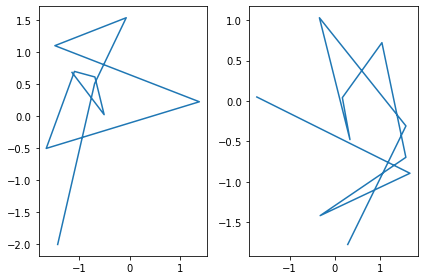

In [4]:


# Constant value copying

# Omega (units are /s which don't make sense, maybe m/s)
w_sub = vval[vname.index('w_sub')]
omega = np.copy(var_4d) # Copy 4D array

# divt and divq (horizontal advection)
q_adv = vval[vname.index('q_adv')]
the_adv = vval[vname.index('the_adv')]

divT = np.copy(var_4d) # Copy 4D array, need to convert to Temp in the array u.del(the)->u.del(T)
divq = np.full_like(var_4d,-0.001*q_adv) # Single value overwrite everywhere, convert g/kg/s->kg/kg/s

# Calculated above
T = np.copy(var_4d)  
q = np.copy(var_4d) 


## Send variables to "dataset" ##
for it in range(0, ntsteps):
   T[it,:,0,0] = temp_plevs.data[:]
   q[it,:,0,0] = q_plevs.data[:]
   divT[it,:,0,0] = the_adv*(plevs/p0)**r_cp # Constant in theta bbut not in T.

   rho = plevs/(r_gas*t_ip)  # Convert dw/dz -> dw/dp
   omega[it,:,0,0] = w_sub/(rho*grav)


## Write To IOP file ##

# 3D #
iop_out.lhflx.attrs = iop_in.lhflx.attrs 
iop_out.shflx.attrs = iop_in.shflx.attrs 

# 4D #
iop_out['T'] = (iop_out_c4, T)
iop_out['q'] = (iop_out_c4, np.float_(q/1000.)) # Funny SCAM requirments

if lno_lsf: # Set ls forcings to zero
    divq.fill(0.) ; divT.fill(0.) ; omega.fill(0.)
    
iop_out['divq'] = (iop_out_c4, divq)
iop_out['divT'] = (iop_out_c4, divT)
iop_out['omega'] = (iop_out_c4, omega)

for iv in iop_out.data_vars:
    iop_out[iv].attrs = iop_in[iv].attrs 
    print(iop_in[iv].attrs)
    iop_out[iv].attrs['_FillValue'] = -9999.
    iop_out[iv].attrs['missing_value'] = -9999. 

## Date stamp ##
iop_out.attrs['creation_date'] = str(dt.datetime.now())

## bdate copy of attributes from old iop and add new value

iop_out['bdate'] = bdate
iop_out['bdate'].attrs = iop_in['bdate'].attrs

#### Send everything to output IOP file
iop_out.to_netcdf(iop_file_out)

##### END #####




fig, axes = mp.subplots(ncols=2, nrows=1)
x_array = np.random.randn(6, 10)
y_array = np.random.randn(6, 10)

i = 0
for row in axes:
    x = x_array[i] 
    y = y_array[i]
    print("hi") 
    row.plot(x, y)
    i += 1
plt.tight_layout()
plt.show()
